# OneEye: Military Airfiled Monitoring with Computer Vision
## AAI-521 Team 1 Final Project

Team 1:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  December 11, 2023

GitHub Repository: https://github.com/t4ai/one-eye-aircraft-detector

In [66]:
!pip install pybboxes

In [67]:
# import base libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
import PIL
import PIL.Image
import xml.etree.ElementTree as ET
import pybboxes as pbx
from pybboxes import BoundingBox
from pathlib import Path

## Exploratory Data Analysis

Scan the images and bounding box labels to understand the nature of the dataset.  Objectives are:

1.  Visualize some sample images
2.  Understand the distribution of image sizes
3.  Understand the distribution of image channels
4.  Analyze the class balances and representation across the dataset
5.  Visualize sample images with horizontal bounding boxes overlaid
6.  Visualize sample images with oriented bounding boxes overlaid

In [68]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# set root folder where dataset is located
ROOT_DIR = '/content/drive/MyDrive/USD/datasets/military_aircraft'
raw_img_dir = pathlib.Path(ROOT_DIR + '/JPEGImages/')
horizontal_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Horizontal Bounding Boxes/').with_suffix('')
oriented_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Oriented Bounding Boxes/').with_suffix('')

### Visualize some sample images

In [71]:
# get paths to images
img_paths = list(raw_img_dir.glob('*.jpg'))

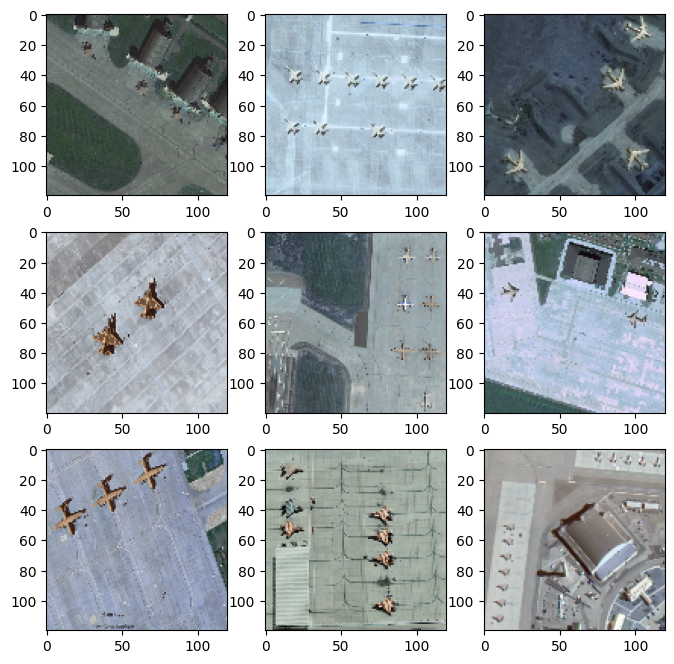

In [ ]:
# visualize some samples from the training data
plt.figure(figsize=(8,8))
for i in range(9):
    rand_img = np.random.randint(0, len(img_paths))
    image = cv2.imread(str(img_paths[rand_img]))
    plt.subplot(3,3,i+1)
    plt.grid(False)
    plt.imshow(cv2.resize(image, (120, 120)))
plt.show()

### Create a distribution of the image sizes to understand the range of sizes

In [ ]:
# helper function to read image files and extract characteristics
def extract_image_characteristics(image_path):

    resolutions = []
    color_distributions = []
    image_channels = []

    imgs = list(image_path.glob('*.jpg'))
    for img in imgs:
        test_img = cv2.imread(str(img))

        # store resolution
        shape = test_img.shape
        resolution = [shape[0], shape[1]]
        resolutions.append(resolution)

        # store image channel count
        if(len(test_img.shape) == 2):
          image_channels.append(1)
        else:
          image_channels.append(test_img.shape[2])

    return resolutions, image_channels

In [ ]:
# compile distribution of sizes
resolution_dist, channel_dist = extract_image_characteristics(raw_img_dir)

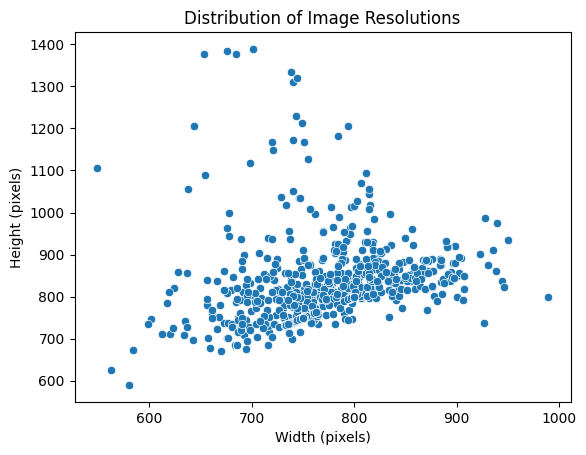

In [ ]:
# Plot a scatter plot of the image resolutions
resolution_dist = np.array(resolution_dist)
sns.scatterplot(x=resolution_dist[:, 0], y=resolution_dist[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

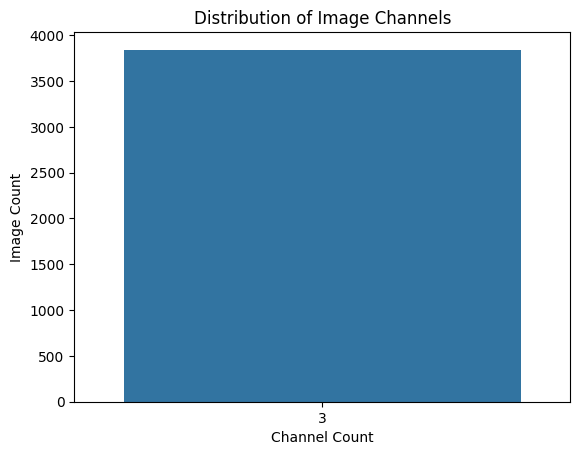

In [ ]:
# Plot histogram to visually analyze distribution
sns.countplot(x=channel_dist)
plt.title("Distribution of Image Channels")
plt.xlabel( "Channel Count" , size = 10)
plt.ylabel( "Image Count" , size = 10)
plt.show()

### Helper functions to process XML label files


In [72]:
# helper function to build class map
def build_class_map(xml_dir):
    class_map = []
    xml_files = list(xml_dir.glob('*.xml'))
    for xml_file in xml_files:
        tree = ET.parse(str(xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            if class_name not in class_map:
                class_map.append(class_name)
    return class_map

# helper function to build class distribution
def build_class_distribution(xml_dir):
    class_dist = {'class': [], 'count': []}
    xml_files = list(xml_dir.glob('*.xml'))
    for xml_file in xml_files:
        tree = ET.parse(str(xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            if class_name not in class_dist['class']:
                class_dist['class'].append(class_name)
                class_dist['count'].append(1)
            else:
                class_dist['count'][class_dist['class'].index(class_name)] += 1
    return class_dist

# helper function to translate bounding boxes to YOLO format for single image
def get_yolo_bounding_box(xmin, ymin, xmax, ymax, width, height):
    yolo_bbox = pbx.convert_bbox((xmin, ymin, xmax, ymax), from_type="voc", to_type="yolo", image_size=(width,height))
    return yolo_bbox

#helper function to translate an image label file to YOLO format
def gen_yolo_label_file(xml_file, class_map, img_dims):
    tree = ET.parse(str(xml_file))
    root = tree.getroot()
    width = img_dims[0]
    height = img_dims[1]
    labels = []
    for obj in root.iter('object'):
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        class_name = obj.find('name').text
        yolo_bbox = get_yolo_bounding_box(xmin, ymin, xmax, ymax, width, height)
        class_id = class_map.index(class_name)
        labels.append([class_id, yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]])
    return labels

# helper function to get image width/height from label file
def get_image_dimensions_from_label(xml_file):
    tree = ET.parse(str(xml_file))
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    return [width, height]


### Load bounding box data and extract class distributions

In [73]:
# build list of class labels
classes = build_class_map(horizontal_xml_dir)

In [ ]:
# check list
print("Total unique class labels:", len(classes))
print("Class labels:", classes)

Total unique class labels: 20
Class labels: ['A6', 'A17', 'A16', 'A15', 'A5', 'A20', 'A14', 'A12', 'A8', 'A2', 'A7', 'A18', 'A13', 'A4', 'A19', 'A1', 'A3', 'A10', 'A11', 'A9']


In [ ]:
# calculate class distribution
class_dist = build_class_distribution(horizontal_xml_dir)

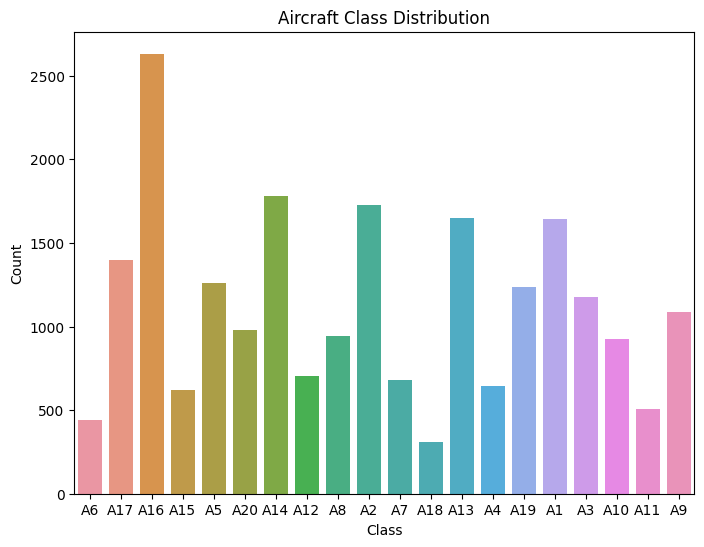

In [ ]:
# visualize class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=class_dist['class'], y=class_dist['count'])
plt.title("Aircraft Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [75]:
# label to class lookup (labels are generic, create mapping to real aircraft names)
aircraft_names = ['SU-35', 'C-130', 'C-17', 'C-5', 'F-16', 'TU-160', 'E-3', 'B-52', 'P-3C', 'B-1B', 'E-8', 'TU-22', 'F-15', 'KC-135', 'F-22', 'FA-18', 'TU-95', 'KC-10', 'SU-34', 'SU-24']
aircraft_lookup = {}
for i in range(len(classes)):
    aircraft_lookup['A' + str(i+1)] = aircraft_names[i]
aircraft_lookup

{'A1': 'SU-35',
 'A2': 'C-130',
 'A3': 'C-17',
 'A4': 'C-5',
 'A5': 'F-16',
 'A6': 'TU-160',
 'A7': 'E-3',
 'A8': 'B-52',
 'A9': 'P-3C',
 'A10': 'B-1B',
 'A11': 'E-8',
 'A12': 'TU-22',
 'A13': 'F-15',
 'A14': 'KC-135',
 'A15': 'F-22',
 'A16': 'FA-18',
 'A17': 'TU-95',
 'A18': 'KC-10',
 'A19': 'SU-34',
 'A20': 'SU-24'}

### Visualize some sample images with bounding boxes overlaid

In [76]:
# helper function to visualize an image with horizontal bb
def visualize_horizontal_bb(img_file, xml_file):
    img = cv2.imread(img_file)
    dh, dw, _ = img.shape
    labels = gen_yolo_label_file(xml_file, classes, [dw, dh])
    for label in labels:
          class_id = label[0]
          x = label[1]
          y = label[2]
          w = label[3]
          h = label[4]
          voc_box = pbx.convert_bbox([x, y, w, h], from_type="yolo", to_type="voc", image_size=(dw, dh))
          voc_x1 = voc_box[0]
          voc_y1 = voc_box[1]
          voc_x2 = voc_box[2]
          voc_y2 = voc_box[3]
          cv2.rectangle(img, (voc_x1, voc_y1), (voc_x2, voc_y2), (0, 0, 255), 2)
          cv2.putText(img, classes[class_id] + ':' + aircraft_lookup[classes[class_id]], (voc_x1, voc_y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(img)
    plt.show()

# helper function to visualize an image with horizontal bb
def visualize_yolo_bb(img, bboxes, labels):
    dh, dw, _ = img.shape
    for i, bbox in enumerate(bboxes):
        class_id = labels[i]
        x = bbox[0]
        y = bbox[1]
        w = bbox[2]
        h = bbox[3]
        voc_box = pbx.convert_bbox([x, y, w, h], from_type="yolo", to_type="voc", image_size=(dw, dh))
        voc_x1 = voc_box[0]
        voc_y1 = voc_box[1]
        voc_x2 = voc_box[2]
        voc_y2 = voc_box[3]
        cv2.rectangle(img, (voc_x1, voc_y1), (voc_x2, voc_y2), (0, 0, 255), 2)
        cv2.putText(img, classes[class_id] + ':' + aircraft_lookup[classes[class_id]], (voc_x1, voc_y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(img)
    plt.show()

# helper function to visualize an image with horizontal bb
def visualize_yolo_bb_labels(img, labels):
    dh, dw, _ = img.shape
    for i, bbox in enumerate(labels):
        class_id = int(bbox[0])
        x = float(bbox[1])
        y = float(bbox[2])
        w = float(bbox[3])
        h = float(bbox[4])
        voc_box = pbx.convert_bbox([x, y, w, h], from_type="yolo", to_type="voc", image_size=(dw, dh))
        voc_x1 = voc_box[0]
        voc_y1 = voc_box[1]
        voc_x2 = voc_box[2]
        voc_y2 = voc_box[3]
        cv2.rectangle(img, (voc_x1, voc_y1), (voc_x2, voc_y2), (0, 0, 255), 2)
        cv2.putText(img, classes[class_id] + ':' + aircraft_lookup[classes[class_id]], (voc_x1, voc_y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(img)
    plt.show()

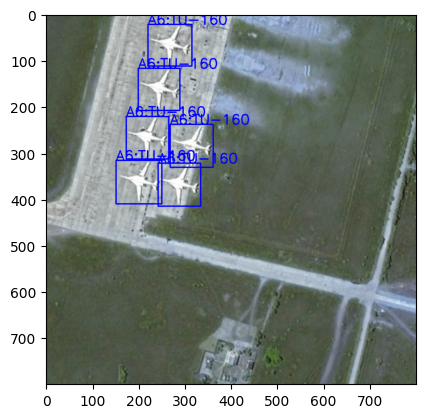

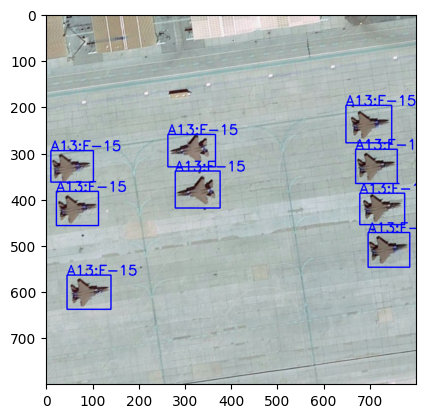

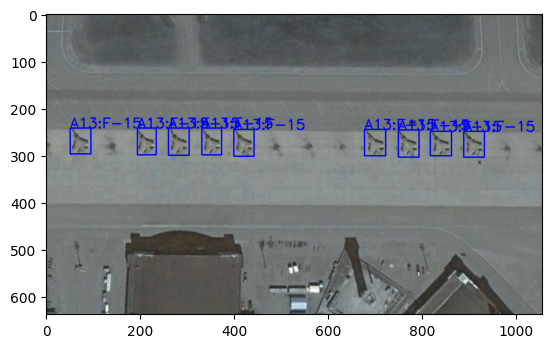

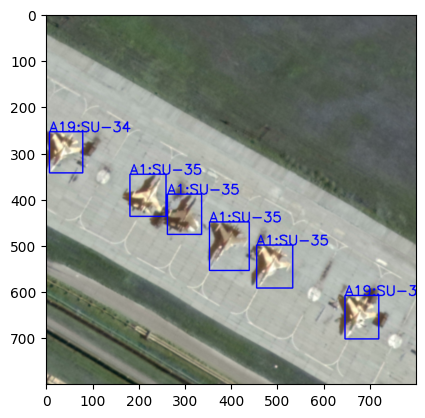

In [ ]:
# visualize some random samples
for i in range(4):
    rand_img = np.random.randint(0, len(img_paths))
    img_file = str(img_paths[rand_img])
    img_number = Path(img_file).stem
    xml_file = str(horizontal_xml_dir.resolve()) + '/' + img_number + '.xml'
    visualize_horizontal_bb(img_file, xml_file)

## Data Augmentation:
Create routines to perform augmentation on images for use in supplementing our training dataset as well as resizing images for to appropriate size for Yolo.  Augmentations implemented in the pipeline:

Augmentation:
-  Randomly flip images horizontally (.5 probability)
-  Randomly rotate images 90 degrees (.5 probability)
-  Randomly adjust brightness and contrast (.2 probability)

Resize:
-  Resize all images to 640x640 (YOLO)


For all above augmentations, bounding boxes are also recalculated as well with respect to the augmentation to maintain correct position over the object.

In [ ]:
pip install -U albumentations

In [ ]:
import albumentations as A

In [ ]:
# helper function to perform augmentation on an image with horizontal bb
def augment_image_bb(img_file, xml_file, transform):
  img = cv2.imread(img_file)
  dh, dw, _ = img.shape
  labels = gen_yolo_label_file(xml_file, classes, [dw, dh])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  bboxes = []
  class_labels = []
  for label in labels:
      class_labels.append(label[0])
      bboxes.append([label[1], label[2], label[3], label[4]])

  augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
  aug_img = augmented['image']
  bboxes = augmented['bboxes']
  labels = augmented['class_labels']

  return aug_img, bboxes, labels

In [ ]:
# Define our augmentation pipeline
augment_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(width=640, height=640),
], bbox_params=A.BboxParams(format='yolo', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

# Define our image resize pipeline
resize_transform = A.Compose([
    A.Resize(width=640, height=640),
], bbox_params=A.BboxParams(format='yolo', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

Original:


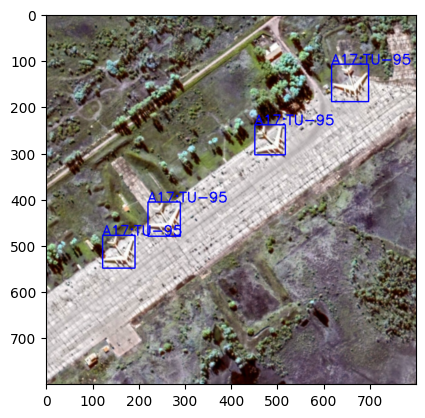

Augmented:


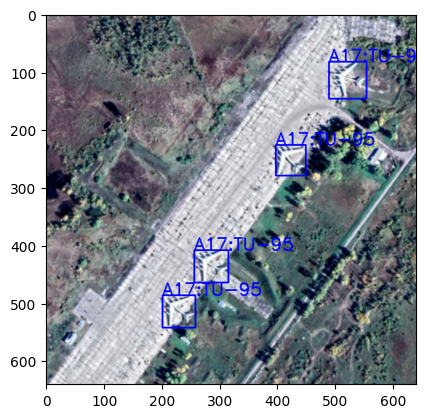

Original:


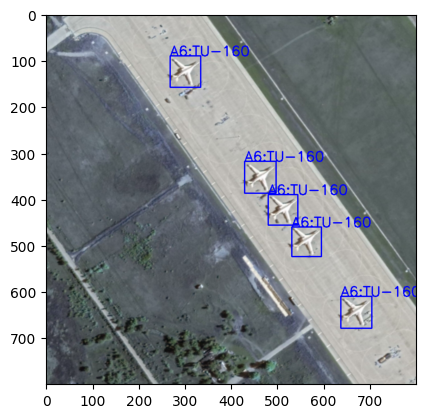

Augmented:


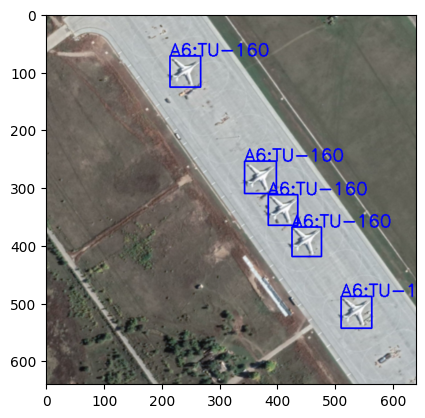

Original:


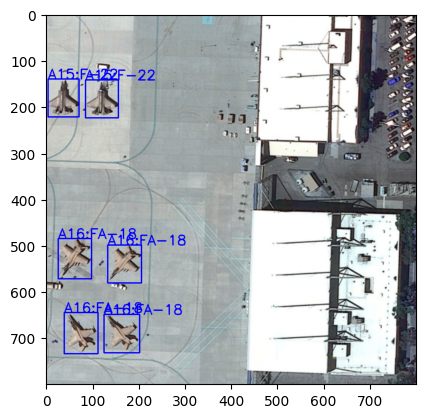

Augmented:


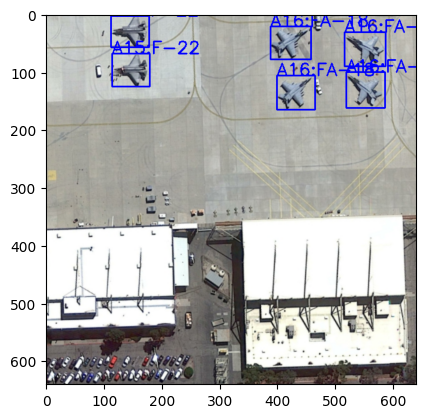

Original:


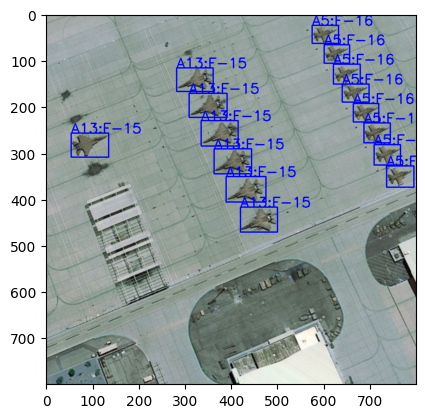

Augmented:


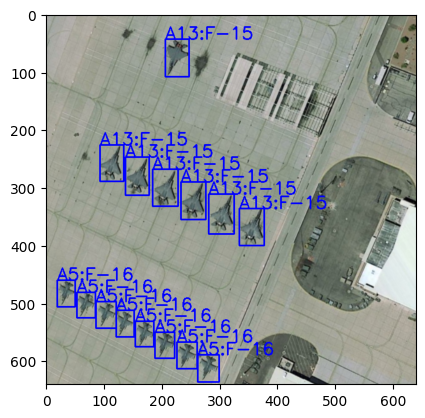

In [ ]:
# augment some random samples to test
for i in range(4):
    rand_img = np.random.randint(0, len(img_paths))
    img_file = str(img_paths[rand_img])
    img_number = Path(img_file).stem
    xml_file = str(horizontal_xml_dir.resolve()) + '/' + img_number + '.xml'
    print("Original:")
    visualize_horizontal_bb(img_file, xml_file)
    print("Augmented:")
    aug_img, aug_bboxes, aug_labels = augment_image_bb(img_file, xml_file, augment_transform)
    visualize_yolo_bb(aug_img, aug_bboxes, aug_labels)

Original:


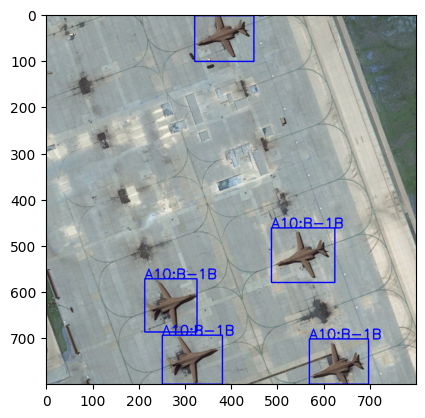

Resized (640x640):


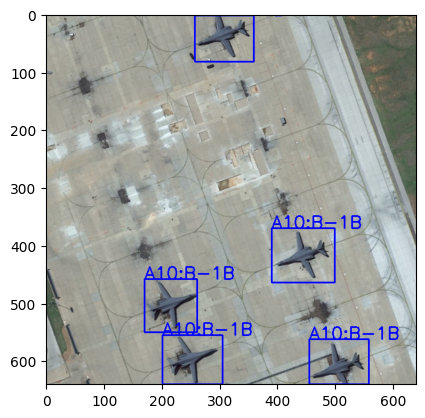

Original:


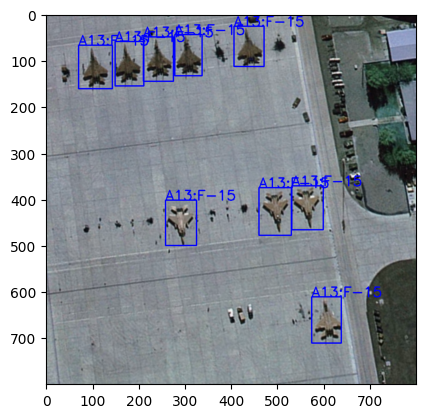

Resized (640x640):


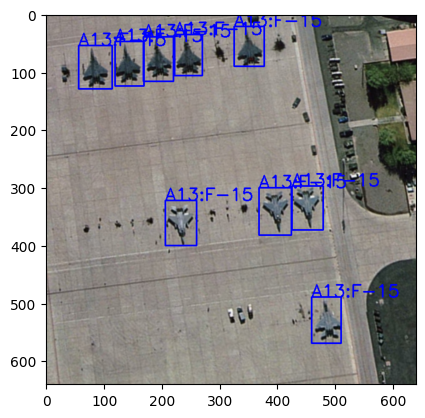

Original:


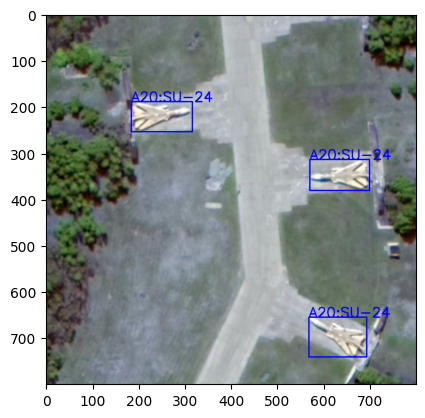

Resized (640x640):


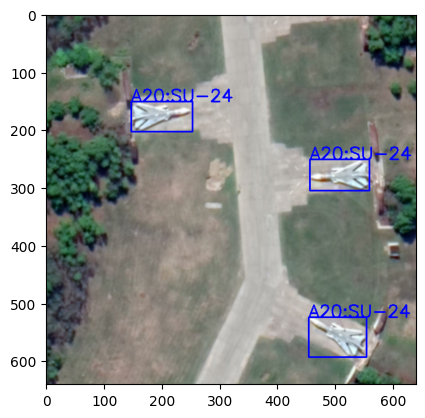

Original:


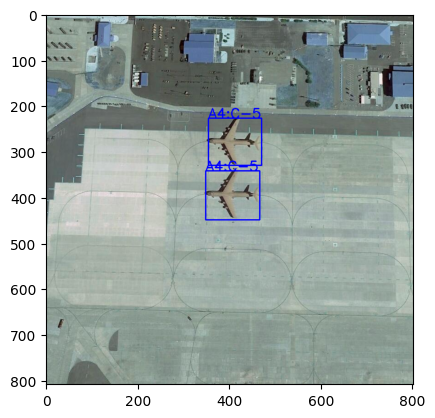

Resized (640x640):


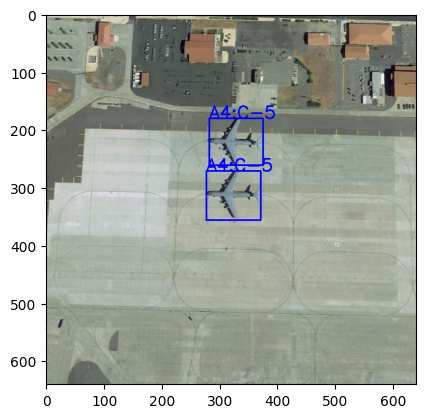

In [ ]:
# resize some random samples to test
for i in range(4):
    rand_img = np.random.randint(0, len(img_paths))
    img_file = str(img_paths[rand_img])
    img_number = Path(img_file).stem
    xml_file = str(horizontal_xml_dir.resolve()) + '/' + img_number + '.xml'
    print("Original:")
    visualize_horizontal_bb(img_file, xml_file)
    print("Resized (640x640):")
    aug_img, aug_bboxes, aug_labels = augment_image_bb(img_file, xml_file, resize_transform)
    visualize_yolo_bb(aug_img, aug_bboxes, aug_labels)

## Data Preparation:
Need to prepare the dataset into a format that is friendly with YOLO model (our intended model architecture to train).  This will require the following steps:

1.  Create folder hierarchy in YOLO format:
        --/train
          --/images
          --/labels
        --/test
          --/images
          --/labels
        --/valid
          --/images
          --/labels
2.  Read in Train/Test split from the ImageSets definition
3.  Perform additional split on test set to create validation set
4.  Traverse the split definitions and for each image:
     - Perform resizing
     - Perform data augmentation
     - Copy images (2:1) to appropriate folder with appropriate filename
     - Copy YOLO label file for each image to appropriate folder with appropriate filename
5.  Generate YAML manifest file for the dataset


In [ ]:
import uuid
import yaml
import shutil
from operator import indexOf

In [85]:
# helper function to write yolo bbox txt file
def write_yolo_label_file(label_file, bboxes, labels):
  with open(label_file, 'w') as f:
    for bbox in bboxes:
      label = str(labels[bboxes.index(bbox)])
      f.write(label + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
      if(indexOf(bboxes, bbox) < (len(bboxes) - 1)):
        f.write("\n")

# helper function to read yolo bbox txt file
def read_yolo_label_file(label_file):
  labels = []
  with open(label_file, 'r') as f:
      lines = f.readlines()
      for line in lines:
        line_exp = line.split()
        labels.append(line_exp)
      return labels

# helper function to transform and write image and labels
def write_yolo_image_set(img, bboxes, labels, target_write_dir, src_img_id):
  target_uuid = str(uuid.uuid4())
  target_img_file = target_write_dir + '/images/' + src_img_id + "_jpg_" + target_uuid + '.jpg'
  target_label_file = target_write_dir + '/labels/' + src_img_id + "_jpg_" + target_uuid + '.txt'
  cv2.imwrite(target_img_file, img)
  write_yolo_label_file(target_label_file, bboxes, labels)

# helper function for loading dataset from imageset
def build_yolo_imageset(imageset_path, target_root_dir):
    with open(imageset_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
          line = line.strip()
          img_file = str(raw_img_dir.resolve()) + '/' + line + '.jpg'
          xml_file = str(horizontal_xml_dir.resolve()) + '/' + line + '.xml'

          # run resize transformation
          resize_uuid = str(uuid.uuid4())
          resize_img, resize_bboxes, resize_labels = augment_image_bb(img_file, xml_file, resize_transform)
          write_yolo_image_set(resize_img, resize_bboxes, resize_labels, target_root_dir, line)

          # run augmentation transformation
          augment_uuid = str(uuid.uuid4())
          aug_img, aug_bboxes, aug_labels = augment_image_bb(img_file, xml_file, augment_transform)
          write_yolo_image_set(aug_img, aug_bboxes, aug_labels, target_root_dir, line)

# split test dataset into test and val
def split_imageset(test_imageset_path, imageset_path, val_percent):
    with open(test_imageset_path, 'r') as f:
        lines = f.readlines()
        val_count = int(len(lines) * val_percent)
        val_lines = lines[0:val_count]
        test_lines = lines[val_count:]
    with open(imageset_path + 'test_split.txt', 'w') as f:
          for line in test_lines:
            f.write(line)
    with open(imageset_path + 'val_split.txt', 'w') as f:
          for line in val_lines:
              f.write(line)
    return imageset_path + 'test_split.txt', imageset_path + 'val_split.txt'

# helper function to build class distribution
def build_class_distribution_yolo(yolo_dir):
    class_dist = {'class': [], 'count': []}
    label_dir = pathlib.Path(yolo_dir).with_suffix('')
    txt_files = list(label_dir.glob('*.txt'))
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
          lines = f.readlines()
          for line in lines:
            label = line.split(" ")
            class_name = classes[int(label[0])]
            if class_name not in class_dist['class']:
                class_dist['class'].append(class_name)
                class_dist['count'].append(1)
            else:
                class_dist['count'][class_dist['class'].index(class_name)] += 1
    return class_dist

# helper function to delete previously generated datase
def delete_dataset(target_root_dir):
    shutil.rmtree(target_root_dir)

In [ ]:
# setup target directories
target_dir = "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo"
train_dir = target_dir + "/train"
test_dir = target_dir + "/test"
val_dir = target_dir + "/valid"

# make root dirs
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# make image dirs
os.makedirs(train_dir + "/images", exist_ok=True)
os.makedirs(test_dir + "/images", exist_ok=True)
os.makedirs(val_dir + "/images", exist_ok=True)

# make label dirs
os.makedirs(train_dir + "/labels", exist_ok=True)
os.makedirs(test_dir + "/labels", exist_ok=True)
os.makedirs(val_dir + "/labels", exist_ok=True)

In [77]:
# set imageset paths
imageset_path = "/content/drive/MyDrive/USD/datasets/military_aircraft/ImageSets/Main/"
train_imageset_path = "/content/drive/MyDrive/USD/datasets/military_aircraft/ImageSets/Main/train.txt"
test_imageset_path = "/content/drive/MyDrive/USD/datasets/military_aircraft/ImageSets/Main/test.txt"


# split test dataset into test and val
split_test_path, split_val_path = split_imageset(test_imageset_path, imageset_path, 0.2)

In [ ]:
# build the yolo imagesets
build_yolo_imageset(train_imageset_path, train_dir)
build_yolo_imageset(split_test_path, test_dir)
build_yolo_imageset(split_val_path, val_dir)

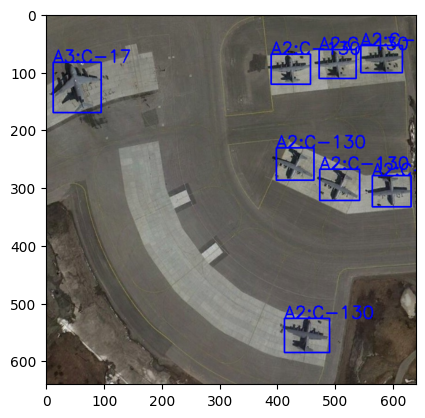

In [ ]:
# test sample
img_file = "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/valid/images/102_jpg_353142b1-0277-4e79-8d09-c716a1d099b3.jpg"
label_file = "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/valid/labels/102_jpg_353142b1-0277-4e79-8d09-c716a1d099b3.txt"
img = cv2.imread(img_file)
labels = read_yolo_label_file(label_file)
visualize_yolo_bb_labels(img, labels)

In [ ]:
# create YAML manifest file
yaml_data = {
    "train": "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/train/images/",
    "test": "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/test/images/",
    "val": "/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/valid/images/",
    "nc": 20,
    "names": classes
}

with open('/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/data.yaml', 'w') as outfile:
    yaml.dump(yaml_data, outfile, default_flow_style=False)

#### Check class distributions (after amentation) of train and test

In [86]:
# build class distribution for training set
train_class_dist = build_class_distribution_yolo(train_dir + "/labels")

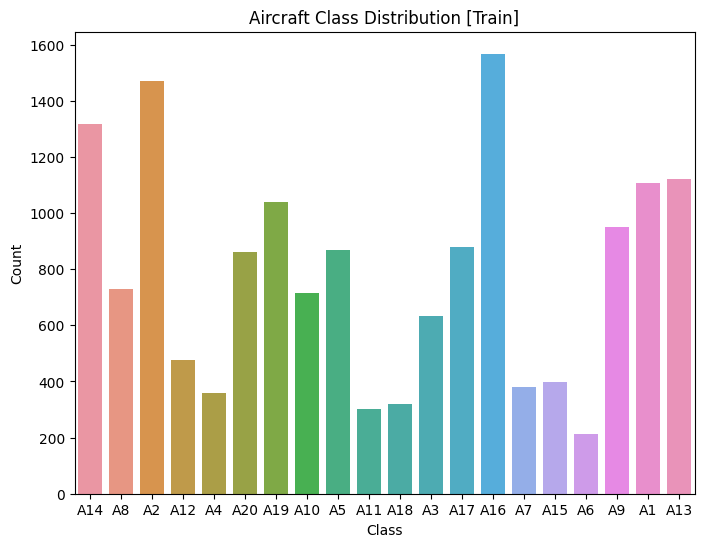

In [87]:
# visualize class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=train_class_dist['class'], y=train_class_dist['count'])
plt.title("Aircraft Class Distribution [Train]")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [88]:
# build class distribution for training set
test_class_dist = build_class_distribution_yolo(test_dir + "/labels")

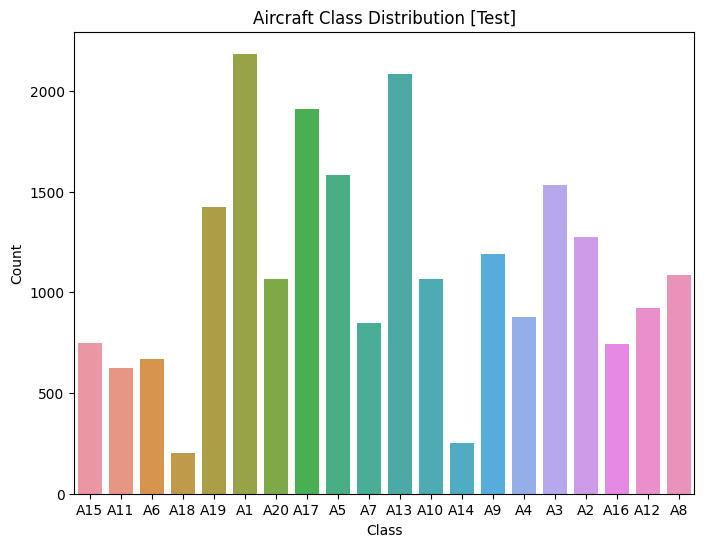

In [89]:
# visualize class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=test_class_dist['class'], y=test_class_dist['count'])
plt.title("Aircraft Class Distribution [Test]")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Model Fine-Tuning and Evaluation:
Fine tune a YOLOv8 model with our prepared dataset and evaluate performance.  


In [90]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 10.7 MB/s eta 0:00:00


In [91]:
from ultralytics import YOLO

In [92]:
# Load pre-rained YOLOv8 model
model = YOLO("yolov8n.yaml")
model = YOLO("yolov8n.pt")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 64.5MB/s]


In [93]:
# Use the model
model.train(
    data="/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/data.yaml",
    epochs=100,
    project="/content/drive/MyDrive/USD/datasets/military_aircraft_exp/",
    name="exp2",
    plots=True
)

# Evaluate on validation data
metrics = model.val()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/USD/datasets/military_aircraft_exp/, name=exp22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, s

100%|██████████| 755k/755k [00:00<00:00, 13.3MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 225 layers, 3014748 parameters, 3014732 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/train/labels... 4018 images, 6 backgrounds, 0 corrupt: 100%|██████████| 4018/4018 [00:45<00:00, 88.94it/s] 


train: New cache created: /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/valid/labels.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G       1.38      3.406      1.204          9        640: 100%|██████████| 252/252 [00:47<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]

                   all       1004       6442     0.0405      0.974       0.14     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.42G      1.193      1.968      1.116         17        640: 100%|██████████| 252/252 [00:38<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


                   all       1004       6442      0.284       0.43      0.276      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      1.124      1.568      1.073         10        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


                   all       1004       6442      0.403      0.417      0.324      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.35G      1.084       1.34      1.063          8        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]

                   all       1004       6442        0.5      0.406       0.42       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.29G      1.054      1.193      1.054          9        640: 100%|██████████| 252/252 [00:37<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


                   all       1004       6442      0.456      0.448      0.424      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.38G       1.02      1.075      1.038         16        640: 100%|██████████| 252/252 [00:37<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]

                   all       1004       6442      0.472      0.459      0.466      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.31G     0.9838     0.9819      1.018         27        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


                   all       1004       6442      0.569      0.487        0.5      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.46G     0.9927     0.9231      1.023         22        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]

                   all       1004       6442      0.532       0.54      0.556      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.35G     0.9671     0.8746      1.017         13        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442       0.54        0.5      0.517      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.31G     0.9551     0.8287      1.017         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]

                   all       1004       6442      0.572      0.566      0.564      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.28G     0.9414     0.7979      1.004         29        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]

                   all       1004       6442      0.554      0.488      0.536      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.37G     0.9349     0.7558      1.004         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.571      0.569      0.557      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G     0.9318     0.7461     0.9997         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.536      0.678      0.559      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.33G     0.9164     0.7145      1.002         18        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       6442      0.577      0.565      0.568      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.25G     0.9133     0.6897     0.9992          5        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1004       6442      0.574       0.62      0.608      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.4G     0.9124     0.6731     0.9948         19        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       6442      0.607      0.579      0.598      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.37G     0.9012     0.6592     0.9876         28        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]

                   all       1004       6442      0.601      0.624      0.594      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.31G     0.8844     0.6398     0.9862         11        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]

                   all       1004       6442      0.568      0.648      0.569      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G     0.8884     0.6414      0.993         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]

                   all       1004       6442      0.608      0.591      0.605      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.25G     0.8667      0.617     0.9786         22        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       6442       0.59      0.589      0.591      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G     0.8749     0.6104     0.9857          6        640: 100%|██████████| 252/252 [00:38<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.591      0.575      0.609      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.24G     0.8707     0.6028     0.9859          4        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       6442      0.595      0.639      0.595      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.25G     0.8642     0.5881     0.9833         21        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]

                   all       1004       6442        0.6      0.618      0.616       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.25G     0.8612     0.5723     0.9795         32        640: 100%|██████████| 252/252 [00:37<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]

                   all       1004       6442      0.602       0.64       0.61      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G     0.8567     0.5705     0.9787          7        640: 100%|██████████| 252/252 [00:38<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]

                   all       1004       6442      0.613      0.652      0.619      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.25G     0.8496     0.5616     0.9745         15        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]

                   all       1004       6442      0.611      0.672       0.61      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G     0.8407      0.552     0.9708         13        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       6442      0.596      0.675      0.608      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.25G     0.8443     0.5478     0.9744          9        640: 100%|██████████| 252/252 [00:38<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1004       6442      0.612      0.675       0.62      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.31G     0.8376     0.5431     0.9698          9        640: 100%|██████████| 252/252 [00:38<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]

                   all       1004       6442      0.634      0.699      0.657      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.45G     0.8373     0.5336     0.9711         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]

                   all       1004       6442      0.575      0.644      0.575      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.24G     0.8266     0.5291     0.9666         45        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]

                   all       1004       6442      0.641      0.662      0.643      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G     0.8223     0.5194     0.9655         18        640: 100%|██████████| 252/252 [00:37<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]

                   all       1004       6442      0.639      0.629      0.636      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.24G     0.8153     0.5163     0.9624         23        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]

                   all       1004       6442      0.644      0.684      0.645      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G     0.8216     0.5148     0.9649         10        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       6442      0.618      0.658       0.62      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.45G     0.8115     0.5037     0.9629         22        640: 100%|██████████| 252/252 [00:37<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.628      0.698      0.621       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.41G     0.8077     0.4998     0.9579         20        640: 100%|██████████| 252/252 [00:38<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]

                   all       1004       6442      0.627      0.665      0.628      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.4G     0.8111      0.507     0.9638          7        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.613      0.641      0.591      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G     0.8076     0.4947     0.9623         14        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]

                   all       1004       6442      0.676      0.654      0.663       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.41G     0.7996     0.4921     0.9598         43        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all       1004       6442       0.67      0.695      0.666       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.35G     0.7981     0.4856     0.9579         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]

                   all       1004       6442      0.621      0.689       0.63      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G     0.7939     0.4853     0.9571         45        640: 100%|██████████| 252/252 [00:38<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]

                   all       1004       6442      0.594      0.661      0.615      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.25G     0.7913     0.4762     0.9576         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.652      0.657      0.675       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G     0.7881     0.4717     0.9539         11        640: 100%|██████████| 252/252 [00:38<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.632      0.669      0.649      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.39G     0.7812     0.4701     0.9535         18        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]

                   all       1004       6442      0.642        0.7      0.669      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.3G     0.7877     0.4629     0.9532          6        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]

                   all       1004       6442      0.617      0.705      0.632      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.35G     0.7815     0.4675     0.9505         27        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all       1004       6442      0.659      0.653      0.659      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.42G     0.7751     0.4615     0.9472         24        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       6442      0.628      0.664      0.625       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G     0.7758      0.458     0.9497          7        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       6442       0.65      0.675      0.649       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.37G     0.7705     0.4501      0.947         21        640: 100%|██████████| 252/252 [00:38<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.681      0.668      0.655       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.32G     0.7699     0.4508     0.9451         31        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]

                   all       1004       6442      0.628      0.649      0.609      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G     0.7648     0.4435      0.945         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]

                   all       1004       6442       0.65      0.676       0.63      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G     0.7594     0.4463     0.9444         18        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       6442      0.632      0.696      0.636      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.41G     0.7589     0.4443     0.9455         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]

                   all       1004       6442      0.646      0.667      0.623       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.25G     0.7614     0.4396     0.9463         20        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1004       6442      0.668      0.706      0.646      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.28G     0.7577     0.4391      0.944         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]

                   all       1004       6442      0.651      0.676      0.625      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.3G     0.7538      0.433     0.9406         28        640: 100%|██████████| 252/252 [00:37<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       6442      0.643      0.697      0.648      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.25G     0.7545     0.4356     0.9412         11        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]

                   all       1004       6442      0.676      0.695      0.667      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.25G     0.7534     0.4407     0.9422          5        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1004       6442       0.63       0.66      0.613       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.27G     0.7441     0.4281       0.94         23        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       6442      0.642      0.692      0.633      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.28G     0.7467      0.426     0.9369         13        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]

                   all       1004       6442      0.625      0.678      0.627       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G     0.7371     0.4185     0.9365         19        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.636      0.671      0.639        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.4G     0.7335     0.4204     0.9335          8        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]

                   all       1004       6442      0.655       0.69      0.633      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.24G     0.7327     0.4198     0.9358         31        640: 100%|██████████| 252/252 [00:38<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.657      0.714      0.642      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.31G     0.7392     0.4204     0.9338         22        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]

                   all       1004       6442      0.629      0.672      0.623      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.4G      0.734     0.4166     0.9345         17        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1004       6442       0.67      0.688      0.644      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G     0.7326     0.4145     0.9352         12        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       6442      0.653      0.684      0.634      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.25G     0.7318     0.4108     0.9317         24        640: 100%|██████████| 252/252 [00:38<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]

                   all       1004       6442      0.635        0.7      0.631      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.24G     0.7262      0.407     0.9301         28        640: 100%|██████████| 252/252 [00:37<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]

                   all       1004       6442      0.645      0.704      0.644      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G     0.7274     0.4118     0.9327         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]

                   all       1004       6442      0.646       0.71       0.64      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.26G     0.7209     0.4041     0.9308         14        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]

                   all       1004       6442      0.673      0.699      0.665      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.39G     0.7187     0.4035     0.9298          7        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all       1004       6442      0.659      0.681      0.639      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G     0.7178     0.4017      0.928         11        640: 100%|██████████| 252/252 [00:38<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]

                   all       1004       6442      0.634      0.692       0.62      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.57G     0.7174     0.4084     0.9285         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1004       6442       0.63      0.693      0.632      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.31G     0.7152     0.3991     0.9295          9        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]

                   all       1004       6442      0.632      0.705      0.653      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.3G     0.7097     0.3939     0.9261         37        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]

                   all       1004       6442      0.645      0.692      0.644      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.31G     0.7091     0.3931     0.9259          9        640: 100%|██████████| 252/252 [00:38<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]

                   all       1004       6442       0.65      0.692      0.633      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.32G     0.7013     0.3886     0.9229          7        640: 100%|██████████| 252/252 [00:37<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all       1004       6442      0.651      0.702      0.656      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.37G     0.7024      0.391     0.9214          6        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       6442      0.651      0.683      0.643      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.39G      0.705     0.3861     0.9238         17        640: 100%|██████████| 252/252 [00:38<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       6442      0.637      0.696      0.637        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.4G     0.7015     0.3829     0.9227         20        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.663      0.691      0.655      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.7006     0.3845     0.9265         16        640: 100%|██████████| 252/252 [00:38<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]

                   all       1004       6442      0.653      0.684      0.646      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.31G     0.6962     0.3865     0.9207         14        640: 100%|██████████| 252/252 [00:38<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]

                   all       1004       6442      0.645      0.689      0.643      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.24G     0.7012     0.3833     0.9209         27        640: 100%|██████████| 252/252 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]

                   all       1004       6442      0.648      0.677      0.639      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.41G     0.6917     0.3808     0.9189         16        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       6442      0.633      0.697      0.634      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.28G     0.6908      0.378     0.9193         17        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       6442      0.627      0.683      0.623      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.26G     0.6904     0.3783     0.9203         19        640: 100%|██████████| 252/252 [00:37<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.637       0.68      0.636        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.28G      0.692     0.3771     0.9187         18        640: 100%|██████████| 252/252 [00:37<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]

                   all       1004       6442      0.637      0.687      0.644      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.39G      0.685     0.3746     0.9175         15        640: 100%|██████████| 252/252 [00:38<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]

                   all       1004       6442      0.638      0.687      0.647      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G     0.6825     0.3733     0.9157         14        640: 100%|██████████| 252/252 [00:38<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1004       6442       0.64      0.688       0.65      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.45G     0.6879     0.3739     0.9144         30        640: 100%|██████████| 252/252 [00:38<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       6442      0.636      0.688      0.648      0.508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.4G     0.6402     0.3151     0.9032         10        640: 100%|██████████| 252/252 [00:40<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]

                   all       1004       6442      0.619      0.687      0.639      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.4G      0.629     0.3095     0.8984         15        640: 100%|██████████| 252/252 [00:38<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]

                   all       1004       6442      0.626      0.673       0.64        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.4G     0.6282     0.3116     0.9014          9        640: 100%|██████████| 252/252 [00:37<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]

                   all       1004       6442      0.633      0.689      0.646      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.39G     0.6234     0.3074      0.898          8        640: 100%|██████████| 252/252 [00:37<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]

                   all       1004       6442      0.653      0.683      0.655      0.516
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 44, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



94 epochs completed in 1.211 hours.
Optimizer stripped from /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3009548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▋         | 2/32 [00:00<00:08,  3.57it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


                   all       1004       6442      0.639      0.678       0.65      0.509
                   A16       1004       2938          1     0.0269       0.51      0.387
                   A15       1004         48      0.533      0.666      0.471      0.388
                    A5       1004         74     0.0793      0.703     0.0771     0.0498
                   A14       1004       1984      0.977       0.37       0.95      0.736
                    A8       1004         72      0.182          1      0.606      0.497
                    A2       1004        646      0.972      0.856      0.982       0.68
                    A7       1004        128      0.832      0.424      0.726      0.514
                   A18       1004         96      0.806      0.433      0.631      0.517
                   A13       1004         56     0.0816      0.875      0.111     0.0753
                    A4       1004         50          1      0.932      0.994      0.887
                    A

val: Scanning /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/valid/labels.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]


                   all       1004       6442      0.641      0.701      0.669      0.523
                   A16       1004       2938          1     0.0285      0.516      0.392
                   A15       1004         48       0.52      0.646      0.468      0.386
                    A5       1004         74     0.0878      0.797     0.0957     0.0622
                   A14       1004       1984      0.978      0.382      0.962      0.743
                    A8       1004         72      0.179          1      0.598       0.49
                    A2       1004        646      0.972      0.857      0.982      0.682
                    A7       1004        128      0.818      0.455      0.739      0.524
                   A18       1004         96      0.817      0.464      0.683      0.556
                   A13       1004         56     0.0816      0.875      0.111     0.0754
                    A4       1004         50          1      0.932      0.994      0.885
                    A

### Evaluate best model against the test dataset

In [94]:
# load fine tuned model
model = YOLO("/content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/weights/best.pt")

In [ ]:
metrics = model.val(
    data="/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/data.yaml",
    split="test",
    project="/content/drive/MyDrive/USD/datasets/military_aircraft_expriments",
    verbose=True
)

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3009548 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 13.4MB/s]
val: Scanning /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/test/labels.cache... 4018 images, 6 backgrounds, 0 corrupt: 100%|██████████| 4018/4018 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/252 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 252/252 [01:10<00:00,  3.56it/s]


                   all       4018      22274      0.842       0.83      0.876      0.662
                    A6       4018        668      0.943      0.918      0.966      0.748
                   A17       4018       1908      0.961      0.951      0.977      0.783
                   A16       4018        742      0.854       0.91      0.882      0.593
                   A15       4018        748      0.338      0.721      0.495      0.314
                    A5       4018       1580      0.815      0.597      0.736      0.488
                   A20       4018       1064      0.829      0.786      0.844      0.619
                   A14       4018        254      0.675      0.852      0.806      0.614
                   A12       4018        922      0.801      0.745      0.849      0.662
                    A8       4018       1086      0.957      0.916      0.963      0.771
                    A2       4018       1276      0.954      0.844      0.947      0.703
                    A

In [95]:
# Evaluate Experiment 2
metrics = model.val(
    data="/content/drive/MyDrive/USD/datasets/military_aircraft_yolo/data.yaml",
    split="test",
    project="/content/drive/MyDrive/USD/datasets/military_aircraft_exp",
    verbose=True
)

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3009548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/test/labels... 2662 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2662/2662 [00:35<00:00, 75.04it/s] 


val: New cache created: /content/drive/MyDrive/USD/datasets/military_aircraft_yolo/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 167/167 [00:28<00:00,  5.76it/s]


                   all       2662      15712      0.845      0.826      0.877      0.696
                    A6       2662        214      0.935      0.981      0.961      0.823
                   A17       2662        878      0.975      0.987       0.99      0.839
                   A16       2662       1568      0.984      0.233      0.798      0.583
                   A15       2662        398      0.504      0.683       0.61       0.43
                    A5       2662        870      0.656      0.638       0.63       0.45
                   A20       2662        860      0.978      0.915      0.987        0.8
                   A14       2662       1318      0.959      0.325      0.726      0.593
                   A12       2662        478       0.89      0.956      0.935      0.726
                    A8       2662        730      0.756      0.953      0.955      0.814
                    A2       2662       1472      0.991      0.866      0.991      0.753
                    A

## Setup Inference Pipeline and Run Samples
Take the best model checkpoint and configure into an inference pipeline.  This pipeline will perform the following tasks:

1.  Read the image
2.  Resize the image to 640x640
3.  Run inference
4.  Resize image + detected bboxes back to original resolution
5.  Translate labels to real aircraft names
6.  Display image with overlaid bboxes and labels


In [98]:
import colorsys
import random

# helper function to generate random colors for class boxes
def generate_label_colors(count):
  colors = []
  for c in range(count):
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r,g,b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    colors.append(tuple([int(r), int(g), int(b)]))
  return colors

# helper function to run model inference
def run_inference(model, img_paths):
  return model.predict(img_paths)

# helper function to process result and return image with bbox overlays
def process_inference_result(result, class_colors):

  # extract result objects
  img = result.orig_img
  dh, dw, _ = img.shape
  boxes = result.boxes.xywhn.tolist()
  labels = [int(label) for label in result.boxes.cls]
  conf = [float(label) for label in result.boxes.conf]

  # create image
  for i, bbox in enumerate(boxes):
    x = bbox[0]
    y = bbox[1]
    w = bbox[2]
    h = bbox[3]
    voc_box = pbx.convert_bbox([x, y, w, h], from_type="yolo", to_type="voc", image_size=(dw, dh))
    voc_x1 = voc_box[0]
    voc_y1 = voc_box[1]
    voc_x2 = voc_box[2]
    voc_y2 = voc_box[3]
    cv2.rectangle(img, (voc_x1, voc_y1), (voc_x2, voc_y2), class_colors[labels[i]], 2)
    cv2.putText(img, aircraft_lookup[classes[labels[i]]]  + ' ' + str(round(conf[i], 2)), (voc_x1, voc_y1-5), cv2.FONT_HERSHEY_SIMPLEX, 1, class_colors[labels[i]], 2)

  return img

def run_process_show(img_path):
  results = model(img_path)
  processed_image = process_inference_result(results[0], rand_class_colors)
  plt.imshow(processed_image)
  plt.show()


In [96]:
# load fine tuned model - best set of weights
model = YOLO("/content/drive/MyDrive/USD/datasets/military_aircraft_exp/exp22/weights/best.pt")

In [99]:
# generate bbox colors for each class
rand_class_colors = generate_label_colors(len(classes))


image 1/1 /content/drive/MyDrive/USD/datasets/edwards.png: 544x640 1 A8, 1 A10, 56.3ms
Speed: 3.0ms preprocess, 56.3ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)


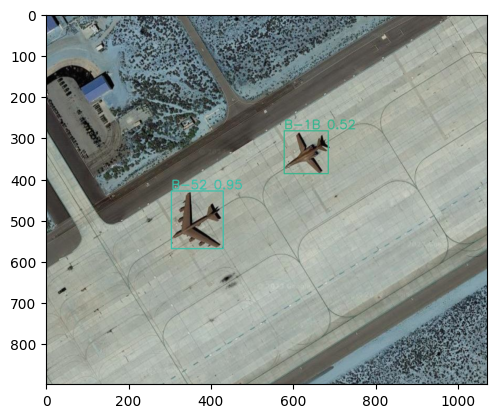

In [100]:
run_process_show("/content/drive/MyDrive/USD/datasets/edwards.png")


image 1/1 /content/drive/MyDrive/USD/datasets/edwards2.png: 608x640 7 A5s, 58.0ms
Speed: 2.9ms preprocess, 58.0ms inference, 2.2ms postprocess per image at shape (1, 3, 608, 640)


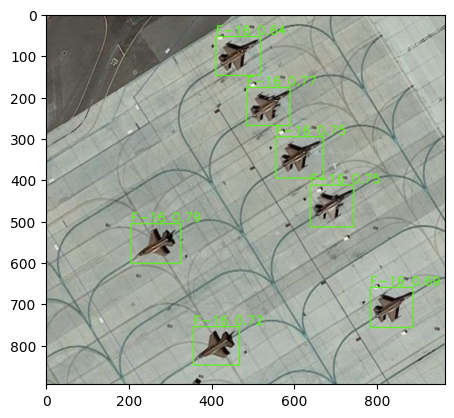

In [101]:
run_process_show("/content/drive/MyDrive/USD/datasets/edwards2.png")